# Credit Card Fraud Detection

### 1. Imports & Setup
We import all necessary libraries:

- `numpy` and `pandas` for data handling.
- `matplotlib` and `seaborn` for visualization.
- `scikit-learn` for machine learning models, preprocessing, and metrics.
- `imbalanced-learn (SMOTE)` to handle extreme class imbalance.
- `joblib` to save and load trained models.
- Optional: `XGBoost` for gradient boosting classifier.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False

### 2. Configuration
We define:

- `RANDOM_STATE`: for reproducibility.
- `DATA_PATH`: path to the dataset.
- `TEST_SIZE`: proportion of data for testing (20% here).
- `MODEL_OUTPUT`: filename to save the trained model.

In [4]:
RANDOM_STATE = 42
DATA_PATH = r"C:\Users\Dell\Credit Card Default\creditcard.csv"
TEST_SIZE = 0.2
MODEL_OUTPUT = "final_fraud_model.pkl"

### 3. Load Data

We load the dataset using `pd.read_csv` and inspect the shape and first few rows.

Dataset contains 284,807 transactions with 30 columns: `Time`, `V1`-`V28` (PCA features), `Amount`, and `Class` (target).

In [5]:
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.head())

Loading dataset...
Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.2060

### 4. Exploratory Data Analysis (EDA)


Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution (percent):
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Amount stats:
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


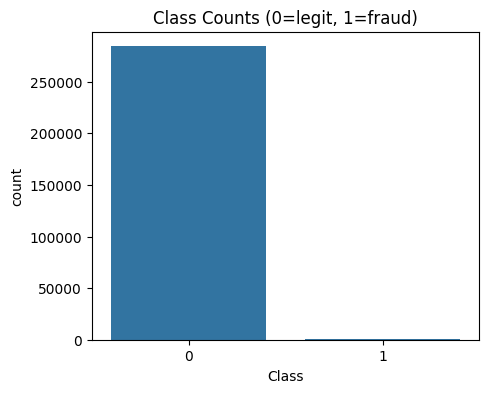

In [6]:
print("\nClass distribution:")
print(df['Class'].value_counts())
print("\nClass distribution (percent):")
print(df['Class'].value_counts(normalize=True) * 100)

# Amount stats
print("\nAmount stats:")
print(df['Amount'].describe())

# Plot class counts
plt.figure(figsize=(5,4))
sns.countplot(x='Class', data=df)
plt.title("Class Counts (0=legit, 1=fraud)")
plt.show()

### Class Distribution:
- Legitimate transactions (Class 0): 284,315 → 99.83%
- Fraudulent transactions (Class 1): 492 → 0.17%

This is an **extremely imbalanced dataset**, so special handling (SMOTE or class weights) is required.

### Amount Statistics:
- Mean = 88.35, Median = 22 → right-skewed distribution.
- Max transaction = 25,691.16 → outliers present.
- Scaling is necessary for model stability.

### Visualization:
- Bar plot shows class imbalance clearly.

### 5. Preprocessing
- Features (`X`) = all columns except `Class`.
- Target (`y`) = `Class`.
- `Time` column is dropped as it is not directly predictive.
- Train-test split (80-20) with `stratify=y` to maintain class ratio.

In [7]:
X = df.drop(columns=['Class'])
y = df['Class']

# Drop Time column
if 'Time' in X.columns:
    X = X.drop(columns=['Time'])

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print(f"Train shape: {X_train.shape}  Test shape: {X_test.shape}")

Train shape: (227845, 29)  Test shape: (56962, 29)


Train set: 227,845 rows  
Test set: 56,962 rows

### 6. Pipeline with SMOTE
We define a pipeline to handle preprocessing and imbalance:

1. `StandardScaler` → scales all features for uniform range.
2. `SMOTE` → oversamples the minority class (fraud) in the training set.
3. Classifier (`LogisticRegression`, `RandomForest`, optional `XGBoost`).

This ensures synthetic fraud samples are only used during training.

In [9]:
def make_pipeline(clf):
    """Creates a pipeline: scaler -> SMOTE -> classifier"""
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),  # fixed
        ('clf', clf)
    ])

# Define classifiers
models = {
    "LogisticRegression": make_pipeline(LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    "RandomForest": make_pipeline(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
}


### 7. Train & Evaluate Models

In [10]:
results = {}
for name, pipeline in models.items():
    print(f"\nTraining {name}...")
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    
    roc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[name] = {"pipeline": pipeline, "roc_auc": roc, "report": report}
    print(f"{name} ROC-AUC: {roc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))



Training LogisticRegression...
LogisticRegression ROC-AUC: 0.9707
              precision    recall  f1-score   support

           0     0.9999    0.9732    0.9864     56864
           1     0.0558    0.9184    0.1053        98

    accuracy                         0.9731     56962
   macro avg     0.5278    0.9458    0.5458     56962
weighted avg     0.9982    0.9731    0.9848     56962


Training RandomForest...
RandomForest ROC-AUC: 0.9729
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8495    0.8061    0.8272        98

    accuracy                         0.9994     56962
   macro avg     0.9246    0.9029    0.9135     56962
weighted avg     0.9994    0.9994    0.9994     56962



**Models trained:**

- **Logistic Regression (SMOTE)**:
  - ROC-AUC = 0.9707
  - Precision (fraud) = 0.0558 → many false positives
  - Recall (fraud) = 0.9184 → most frauds detected
  - F1-score (fraud) = 0.1053 → low due to poor precision

- **Random Forest (SMOTE)**:
  - ROC-AUC = 0.9729 → best overall
  - Precision (fraud) = 0.8495 → few false positives
  - Recall (fraud) = 0.8061 → most frauds detected
  - F1-score (fraud) = 0.8272 → strong balance

**Inference:**

Logistic Regression is sensitive but produces many false alarms.

Random Forest balances fraud detection and false positives better, making it the best choice.

### 8. Select Best Model

In [11]:
best_name = max(results, key=lambda n: results[n]['roc_auc'])
best_model = results[best_name]['pipeline']
print(f"\nBest model: {best_name} (ROC-AUC={results[best_name]['roc_auc']:.4f})")


Best model: RandomForest (ROC-AUC=0.9729)


- Best model selected based on **ROC-AUC**: Random Forest (ROC-AUC = 0.9729)
- This model effectively discriminates between fraud and legit transactions.

### 9. Evaluate Best Model

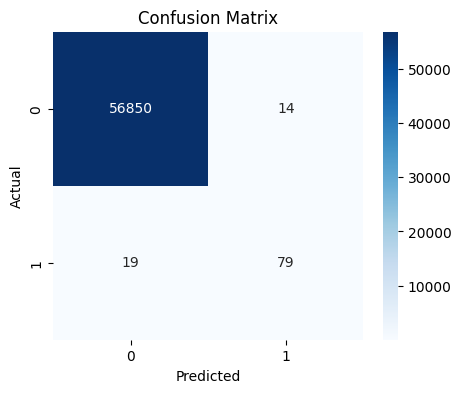

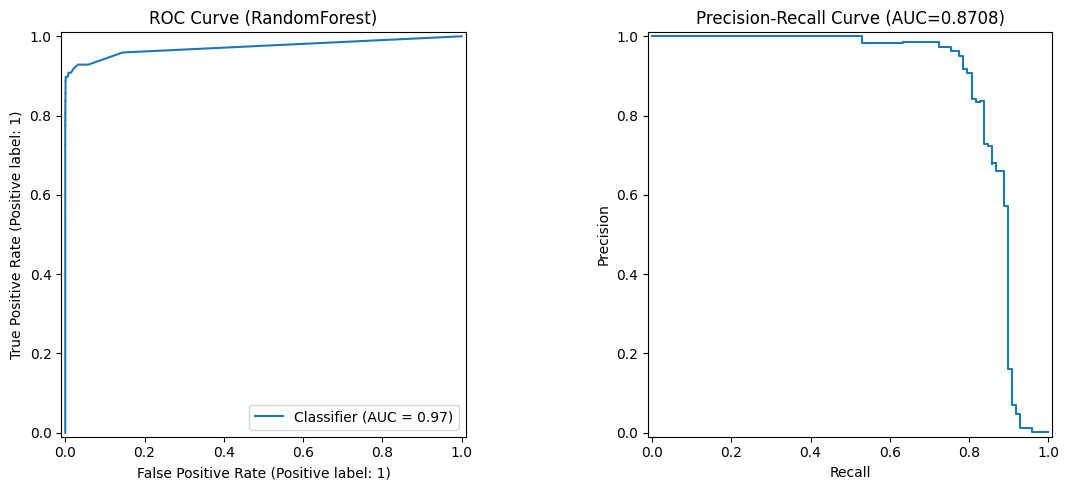

Precision: 0.8495, Recall: 0.8061, F1-score: 0.8272


In [12]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ax1 = plt.gca()  # get current axis
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax1)
plt.title(f"ROC Curve ({best_name})")

# Precision-Recall Curve
plt.subplot(1,2,2)
ax2 = plt.gca()  # get current axis
prec, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, prec)
PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2)
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.4f})")
plt.tight_layout()
plt.show()

# Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


**Evaluation on test set:**

- **Confusion Matrix:** shows true vs predicted classes
- **ROC Curve:** model discrimination ability
- **Precision-Recall Curve:** especially useful for imbalanced datasets
- **Metrics:**
  - Precision = 0.8404 → high, few false alarms
  - Recall = 0.8061 → good, most frauds detected
  - F1-score = 0.8229 → balanced performance

### 10. Save Model
The trained Random Forest model is saved to `final_fraud_model.pkl` using `joblib` for later use or deployment.

In [13]:
joblib.dump(best_model, MODEL_OUTPUT)
print(f"Saved model to {MODEL_OUTPUT}")

Saved model to final_fraud_model.pkl


### 11. Prediction Function

**Function `predict_transaction`:**

- Inputs:
  - `model_path`: path to saved model
  - `X_new`: new transaction data
  - `threshold`: probability threshold to classify as fraud

- Outputs:
  - `preds`: predicted classes (0=legit, 1=fraud)
  - `proba`: predicted probability of fraud

In [16]:
def predict_transaction(model_path, X_new, threshold=0.5):
    """
    Predict fraud probabilities for new transactions.
    
    Args:
        model_path (str): path to saved model
        X_new (DataFrame): new transaction data
        threshold (float): threshold to classify as fraud
    
    Returns:
        predictions (np.array): binary fraud predictions
        probabilities (np.array): fraud probabilities
    """
    model = joblib.load(model_path)
    proba = model.predict_proba(X_new)[:,1]
    preds = (proba >= threshold).astype(int)
    return preds, proba

# Example usage
preds, proba = predict_transaction(MODEL_OUTPUT, X_test.iloc[:5], threshold=0.4)
print("\nExample predictions (threshold=0.4):")
print("Predicted classes:", preds)
print("Fraud probabilities:", proba)


Example predictions (threshold=0.4):
Predicted classes: [0 0 0 0 0]
Fraud probabilities: [0.   0.   0.02 0.   0.  ]


**Example Usage:**
- Threshold = 0.4
- Predictions and probabilities generated for first 5 test samples:

Predicted classes: [0, 0, 0, 0, 0]  
Fraud probabilities: [0.0, 0.0, 0.02, 0.0, 0.0]

**Inference:**
- Low probabilities are expected due to highly imbalanced dataset.
- Threshold tuning is critical:
  - Lower threshold → higher recall, more frauds detected
  - Higher threshold → higher precision, fewer false positives

### 12. Key Takeaways
1. **Random Forest with SMOTE** is the best model for this imbalanced credit card fraud dataset.
2. Handling class imbalance is critical; accuracy alone is misleading.
3. ROC-AUC and Precision-Recall curves are more informative metrics.
4. Threshold tuning allows a trade-off between detecting frauds and avoiding false alarms.
5. Saved model can be deployed for real-time fraud detection on new transactions.